## 背景说明

随着人们生活水平的提高，越来越多的人们选择假期旅游，然而节假日大量的人员流动造成了热门景点附近的地铁站人员密集，若遇突发情况，人员无法有效疏散。在此背景下，通过对地铁站人流量数据进行分析，推测出人员密集区域和高峰时段，从而提前做好准备，为合理疏导人群、规避交通堵塞提供预警服务。

### 数据样例

&emsp;&emsp;1、`data.csv` 包含 `2022-01-01.csv` 至`2022-01-10.csv`共`20天`的地铁站数据，共`20万`条。

| 列名 | 类型 | 说明 | 示例 |
| ---- | ---- | ---- | ---- |
| time | String | 刷卡发生时间 | 2022-01-01 02:00:05 |
| lineID | String | 地铁线路ID | B |
| stationID | int | 地铁站ID | 27 |
| deviceID | int | 刷卡设备编号ID | 1354 |
| status | int | 进出站状态，0为出站，1为进站 | 0 |
| userID | String | 用户身份ID | D13f76f42c9a677c4add94d9e480fb5c5 |
| payType | int | 用户刷卡类型 | 3 |

&emsp;&emsp;2、`Metro_roadMap.csv` 是一个81x81的二维矩阵。文件中首行和首列表示地铁站ID（stationID），columns为0-80，rows为0-80。roadMap[i][j] = 1 表示stationID为i的地铁站和stationID为j的地铁站直接相连；roadMap[i][j] = 0 表示stationID为i的地铁站和stationID为j的地铁站不相连。

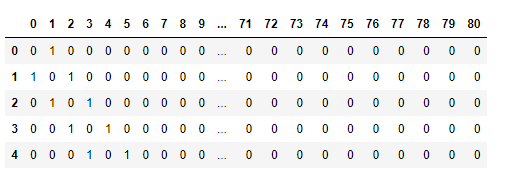

### 分析思路

1.对数据整体进行观察。由于数据中存在不合法的数据，如：0点后仍有刷卡记录以及一些值为NaN的数据等，将这类数据进行剔除。对清洗后的数据进行统计。<br>
2.分析线路、站点、设备之间的关系。利用分组聚合，分析线路、站点、设备之间的数量关系，并使用matplotlib进行可视化分析。<br>
3.分析用户、刷卡类型、时间段之间的关系。利用分组聚合，分析每个时间段的用户数量，并可视化，以便于查看什么时间亦或哪条线路用户进出站达到峰值。<br>
4.分析地铁站点在三条线路的分布情况。利用分组聚合，以线路A为例，对1月1日至1月20日共计20天内的地铁站点（站67到站80）人流量进行分析，并使用饼状图对每个站点的情况进行展示。<br>
5.按时间段分析线路A、B、C各站的人流量情况。利用分组聚合的方式统计 `早高峰[7:00-9:00]` 和 `晚高峰[17:00-20:00]`的进出站人数，并利用pyecharts库进行地图可视化。

### 0、导包

- 导入数据分析所用的第三方库：`numpy、pandas、matplotlib`；

- 为了防止`matplotlib`画图例时中文乱码情况，下面给出 `2种` 解决方案：

- 第一种：

    - - 1、第一步：安装mplfonts库`!pip install mplfonts -i https://pypi.tuna.tsinghua.edu.cn/simple` 

    - - 2、第二步：添加下列代码： 

    - - `from mplfonts import use_font`
    - - `use_font('Noto Serif CJK SC')#指定中文字体`
    
- 第二种：
    - -  &emsp;1、升级matplotlib
    - -  &emsp;2、写入如下代码
    - - &emsp;`# 设置显示中文字体，# 设置font.sans-serif 或 font.family 均可
plt.rcParams["font.sans-serif"] = ["Arial Unicode MS"] ## mac
plt.rcParams['font.family']=['Arial Unicode MS'] ## mac
plt.rcParams["font.sans-serif"] = ["SimHei"] ## win
plt.rcParams['font.family']=['SimHei'] ## win
plt.rcParams["axes.unicode_minus"] = False # 设置正常显示符号`

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt

# 设置显示中文字体，
# 设置font.sans-serif 或 font.family 均可
plt.rcParams["font.sans-serif"] = ["Arial Unicode MS"]  ## mac
plt.rcParams['font.family'] = ['Arial Unicode MS']  ## mac
#plt.rcParams["font.sans-serif"] = ["SimHei"] ## win
#plt.rcParams['font.family']=['SimHei'] ## win
# 设置正常显示符号
plt.rcParams["axes.unicode_minus"] = False

### 1、数据观察

- 查看数据样本信息，如一条数据样本中包含哪些属性；
- 查看数据类型，判断是否需要转换数据格式；
- 查看数据是否有缺失、无效等情况，若有则对数据进行清洗；

#### 1.1 观察数据

In [10]:
parent_path = os.path.abspath(os.pardir)
dataPath = os.path.join(parent_path + '/dataset' + '/subway_data.csv')
df = pd.read_csv(dataPath)
df.head()  #查看数据样式

,time,lineID,stationID,deviceID,status,userID,payType
0,2022-01-01 14:34:23,B,19,1006,1,Cff263245447d6ad1fbc2c6166582234e,2
1,2022-01-01 18:35:52,C,47,2271,1,A27aff32d8340333a616d62e12434ccbe,0
2,2022-01-01 19:35:45,B,17,952,1,Bedb7c79d26ae95c2a9f14b51b3797ed8,1
3,2022-01-01 21:00:03,B,27,1351,1,Cb32ccd5e11669b4c7c5e59fc3ffe7dba,2
4,2022-01-01 15:47:29,B,0,0,0,D964f8837a1a6326d0fe6bb36457874de,3


In [3]:
# 查形状
df.shape

(200000, 7)

In [4]:
# 查看数据类型
df.dtypes

time         object
lineID       object
stationID     int64
deviceID      int64
status        int64
userID       object
payType       int64
dtype: object

In [5]:
df.describe()

,stationID,deviceID,status,payType
count,200000.000000,200000.000000,200000.000000,200000.000000
mean,32.335170,1552.001955,0.499205,1.383740
std,23.208249,1061.014492,0.500001,0.844498
min,0.000000,0.000000,0.000000,0.000000
25%,12.000000,641.000000,0.000000,1.000000
50%,25.000000,1273.000000,0.000000,1.000000
75%,52.000000,2533.000000,1.000000,2.000000
max,80.000000,3638.000000,1.000000,3.000000


### 结论

- lineID的范围是{A, B, C}，有 3 条线路
- staionID的范围是[0，80]，有81个站点
- deviceID的范围是[0,3638]，有3639个刷卡设备
- status的范围是{0,1}，0为出站，1为进站
- payType的范围是{0,1,2,3}

## 1.2 数据类型转换

- 1、`time` 列为方便后面计算，修改为可计算类型'datetime'
- 2、`time` 列为方便后面计算，将原始数据 `2022-01-01 14:34:23` 拆成 `2022-01-01` 和 `14:34:23` 两列

In [11]:
df['time'] = pd.to_datetime(df['time'], format='%Y-%m-%d %H:%M:%S')
df['date1'] = df['time'].dt.strftime('%Y-%m-%d')
df['date2'] = df['time'].dt.strftime('%H:%M:%S')
df['hours'] = df['time'].dt.hour
df.head()

,time,lineID,stationID,deviceID,status,userID,payType,date1,date2,hours
0,2022-01-01 14:34:23,B,19,1006,1,Cff263245447d6ad1fbc2c6166582234e,2,2022-01-01,14:34:23,14
1,2022-01-01 18:35:52,C,47,2271,1,A27aff32d8340333a616d62e12434ccbe,0,2022-01-01,18:35:52,18
2,2022-01-01 19:35:45,B,17,952,1,Bedb7c79d26ae95c2a9f14b51b3797ed8,1,2022-01-01,19:35:45,19
3,2022-01-01 21:00:03,B,27,1351,1,Cb32ccd5e11669b4c7c5e59fc3ffe7dba,2,2022-01-01,21:00:03,21
4,2022-01-01 15:47:29,B,0,0,0,D964f8837a1a6326d0fe6bb36457874de,3,2022-01-01,15:47:29,15


#### 1.3 清除异常值

- 假设地铁早上6：00开门，晚上 23：00关门

-  删除符合条件的指定行，并替换原始df

In [12]:
print("原始数据：", df.shape[0])
# 假设地铁早上6：00开门，晚上 23：00关门
D = df[(df['hours'] <= 6) | (df['hours'] >= 23)]
print("异常值：", D.shape[0])

# 删除符合条件的指定行，原表也变
df.drop(df[(df['hours'] <= 6) | (df['hours'] >= 23)].index, inplace=True)
df.shape

原始数据： 200000
异常值： 4257


(195743, 10)

In [14]:
# 查看地铁矩阵图
import seaborn as sns

road_map = pd.read_csv(parent_path + '/dataset/Metro_roadMap.csv')
print(road_map.shape)  #多了一列Unnamed
road_map = road_map.drop(['Unnamed: 0'], axis=1)
road_map.head(5)

(81, 82)


,0,1,2,3,4,5,6,7,8,9,...,71,72,73,74,75,76,77,78,79,80
0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,1,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,1,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


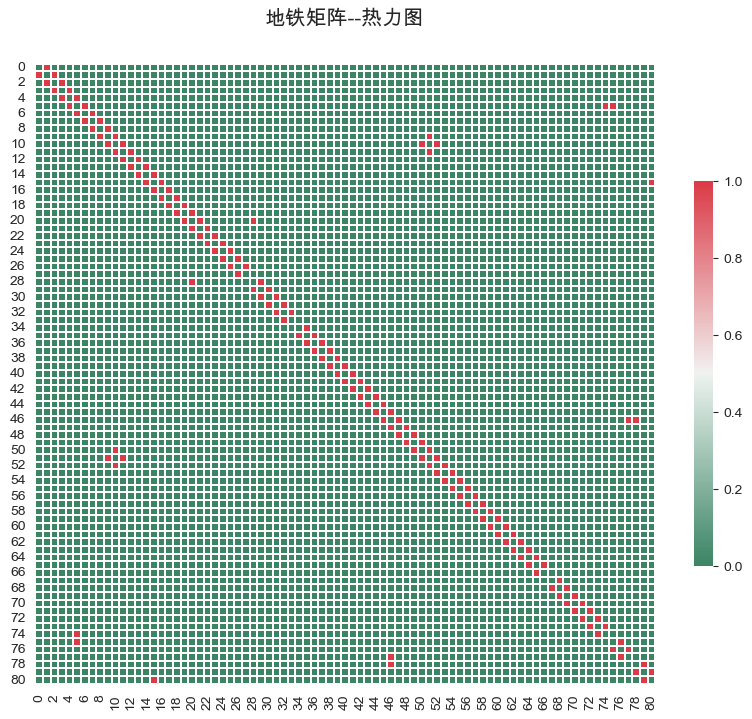

In [17]:
# TODO: 地铁矩阵--热力图
# correlation heatmap of dataset
def correlation_heatmap(df):
    _, ax = plt.subplots(figsize=(10, 10))
    colormap = sns.diverging_palette(150, 10, as_cmap=True)

    _ = sns.heatmap(
        df,
        cmap=colormap,
        square=True,
        cbar_kws={'shrink': .5},
        ax=ax,
        linewidths=0.1, vmax=1.0, linecolor='white',
    )

    plt.title('地铁矩阵--热力图', y=1.05, size=15)


correlation_heatmap(road_map)

- 地铁热力图分析

1、中间正对角线方向可以发现i,j相连表现的是上下站的连接  (参考：roadMap[i][j] = 1 表示stationID为i的地铁站和stationID为j的地铁站直接相连；roadMap[i][j] = 0 表示stationID为i的地铁站和stationID为j的地铁站不相连。)<br>
2、其余剩下10个零散点为重点研究对象，可列表统计


| 站点i | 站点j |
| ---- | ---- |
| 28 | 20 |
| 51 | 9 |
| 50 | 10 |
| 51 | 11 |
| 52 | 10 |
| 74 | 5 |
| 75 | 5 |
| 80 | 15 |
| 77 | 46 |
| 78 | 46 |

### 2、线路、站点、设备数分析

- 1、基本统计：线路、站点、设备数的基本情况；
- 2、借助分组聚合，分析每条线路的站点数；
- 3、利用 `groupby` 查看每条线路记录数最多的站点；
- 4、假设：越大的站点设备数越多。比如换乘站和人流密集站点会有多个出口；查看设备数最多的站点

#### 绘制地铁线路数值分布图柱状图

LineA记录数: 21139
LineB记录数: 112122
LineC记录数: 62482


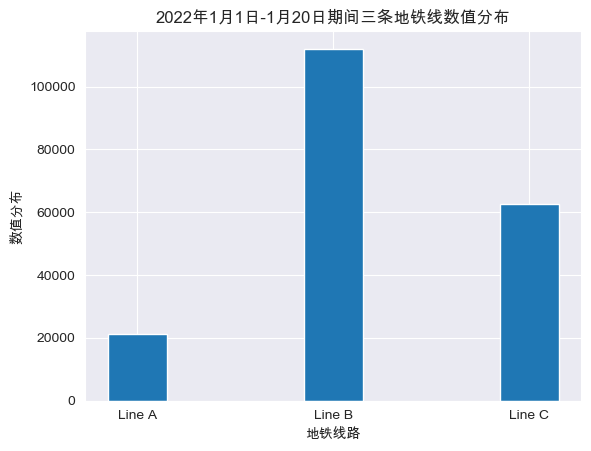

In [20]:
# 每条线路的人流量分布情况
y_A = df[df['lineID'] == 'A'].shape[0]
y_B = df[df['lineID'] == 'B'].shape[0]
y_C = df[df['lineID'] == 'C'].shape[0]

# 打印每条线路的记录总数，作为数值考核
print("LineA记录数:", y_A, end='\n')
print("LineB记录数:", y_B, end='\n')
print("LineC记录数:", y_C, end='\n')

x = ['Line A', 'Line B', 'Line C']
y = [y_A, y_B, y_C]

plt.title('2022年1月1日-1月20日期间三条地铁线数值分布')
plt.bar(x, y, width=0.3, label="线路分布")
plt.xlabel("地铁线路")  #给x轴起名字
plt.ylabel("数值分布")  #给y轴起名字
plt.show()

In [19]:
df.shape

(195743, 10)

#### 使用seaborn库绘制地铁各个站点压力分布柱状图

In [21]:
## 绘制条形图：站点压力分布图
number_of_stationID = df.stationID.value_counts()
print(number_of_stationID)

stationID
15    16001
9      8810
4      5573
7      5489
10     4726
      ...  
35      706
28      672
31      656
72      643
74      523
Name: count, Length: 80, dtype: int64


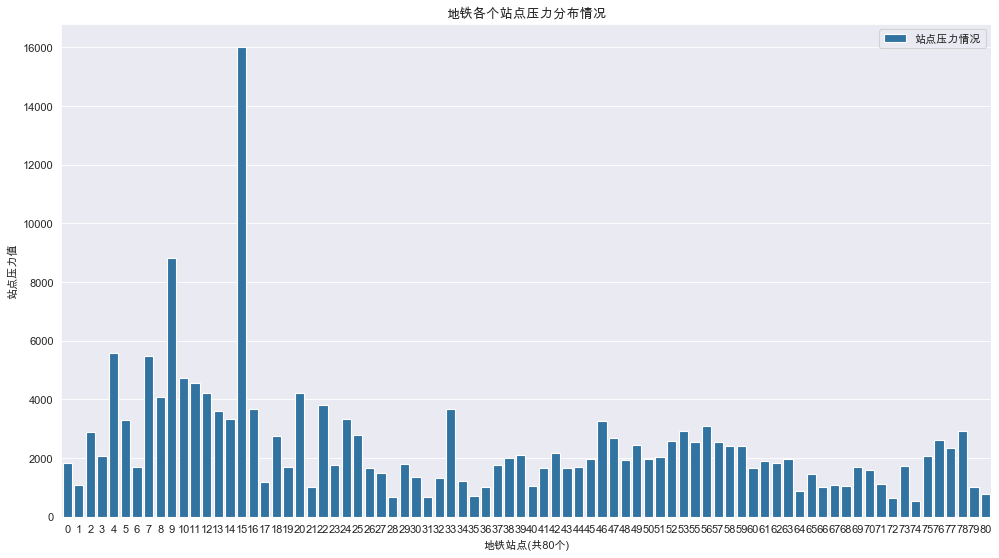

In [22]:
fig = plt.figure(figsize=(15, 8), dpi=80)

plt.title('地铁各个站点压力分布情况')
ax = sns.barplot(x=number_of_stationID.index, y=number_of_stationID, label="站点压力情况")
plt.ylabel("站点压力值")
plt.xlabel("地铁站点(共80个)")
plt.legend()
plt.show()

<font size=5> **小结** </font>

- 1、路线B是最繁忙的，大概11w条记录，占到总量的57%；路线C有6w条左右记录；路线A最少，2w条左右记录
- 2、最繁忙的站点是站点15，1w多条记录，其次是9站点，8810条记录

#### 根据 `lineID列` 对 `stationID`进行分组聚合分析，并转换为DataFrame

In [29]:
# 通过分组聚合查看每条路线的站点数
a = df.groupby('lineID')['stationID'].nunique()
LineStation = pd.DataFrame(a)
LineStation.head()

,stationID
lineID,
A,14
B,34
C,32


#### 筛选出`线路ABC`的进出站数据

In [30]:
# 计算每条线路的进出站情况, 0为出站，1为进站
A_status_1 = df[(df['lineID'] == 'A') & (df['status'] == 1.0)].shape[0]
A_status_0 = df[(df['lineID'] == 'A') & (df['status'] == 0.0)].shape[0]

# 筛选线路B的进出站数据
B_status_1 = df[(df['lineID'] == 'B') & (df['status'] == 1.0)].shape[0]
B_status_0 = df[(df['lineID'] == 'B') & (df['status'] == 0.0)].shape[0]

# 筛选线路C的进出站数据
C_status_1 = df[(df['lineID'] == 'C') & (df['status'] == 1.0)].shape[0]
C_status_0 = df[(df['lineID'] == 'C') & (df['status'] == 0.0)].shape[0]

# 数值打印
print("线路A进出站数据：", A_status_1, A_status_0)
print("线路B进出站数据：", B_status_1, B_status_0)
print("线路C进出站数据：", C_status_1, C_status_0)

线路A进出站数据： 10512 10627
线路B进出站数据： 55899 56223
线路C进出站数据： 30966 31516


#### 绘制三条线路的进出站情况(柱状图)

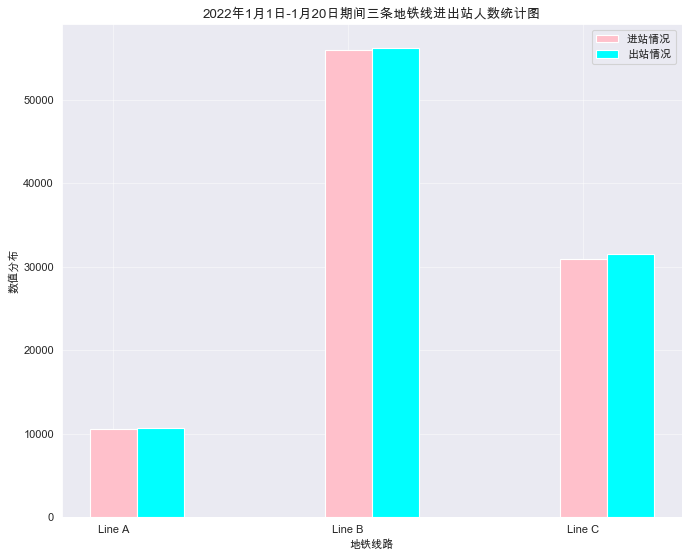

In [31]:
# 画出三条线路的进出站情况图
x = ['Line A', 'Line B', 'Line C']

y_1 = [A_status_1, B_status_1, C_status_1]  # 进站数据
y_2 = [A_status_0, B_status_0, C_status_0]  # 出站数据

# 一个柱状图画完之后，往x轴左移
bar_width = 0.2  # 设置柱状图大小不能超过0.3
x_1 = list(range(len(x)))
x_2 = [i + bar_width for i in x_1]

# 设置图片大小
fig = plt.figure(figsize=(10, 8), dpi=80)

# 设置网格
plt.grid(alpha=0.5)
plt.title('2022年1月1日-1月20日期间三条地铁线进出站人数统计图')

# 绘制三条地铁线进出站人数柱状图
plt.bar(range(len(x)), y_1, width=bar_width, color='#FFC0CB', label="进站情况")
plt.bar(x_2, y_2, width=bar_width, color='#00FFFF', label="出站情况")

#给x、y轴起名字
plt.xlabel("地铁线路")
plt.ylabel("数值分布")

# 设置图列
plt.legend()

# 调整x轴
plt.xticks(range(len(x)), x)

# 显示图片
plt.show()

<font size=5> **小结** </font>

- 1、根据分析结果可知，线路A有 `14个` 地铁站点，线路B有 `34个` 地铁站点，线路C有 `32个` 地铁站点；
- 2、根据图示结果，可以很清晰的发现，线路B的进出站压力相较于A和C较大，可以考虑在线路B上增设地铁站点。

In [33]:
# 假设：越大的站点设备数越多。比如换乘站和人流密集站点会有多个出口
# 查看各站点设备刷卡记录数
# pd.set_option('display.max_rows', None)
df.groupby('stationID')['deviceID'].nunique()

stationID
0     18
1     13
2     14
3     14
4     28
5     43
6     17
7     26
8     32
9     31
10    20
11    21
12    25
13    14
14    18
15    67
16    44
17    13
18    13
19    14
20    37
21    14
22    21
23    14
24    21
25    28
26    21
27    20
28    17
29    21
30    21
31    15
32    15
33    20
34    19
35    14
36    14
37    15
38    15
39    19
40    11
41    19
42    19
43    26
44    23
45    27
46    41
47    22
48    16
49    25
50    21
51    26
52    25
53    19
55    19
56    19
57    17
58    22
59    27
60    19
61    20
62    21
63    30
64    14
65    24
66    19
67    11
68    16
69    22
70    15
71    13
72    14
73    22
74    14
75    24
76    26
77    26
78    17
79    11
80    14
Name: deviceID, dtype: int64

<font size=5>  **小结** </font>

<font size=4>分析前提：假设越大的站点设备数越多，如换乘站和人流密集站点会有多个出口</font>

- 根据上述分析可得，最繁忙的15、9站点都在路线B上；站点15的设备数有`67`个，后期可以适当增加。

### 3、用户、刷卡类型

- 分析用户ID是否唯一
- 分析同一刷卡类型下，用户分布情况
- 用户当天乘坐地铁情况分析

### 分析不同刷卡类型用户分布情况

In [35]:
# 用户数
print('用户数：', df.userID.nunique())

# 刷卡类型
print('刷卡类型统计：', df.payType.value_counts())

# 刷卡类型用户分布
print('刷卡类型用户分布：', df.groupby('payType')['userID'].nunique())

用户数： 184146
刷卡类型统计： payType
1    91049
2    58086
0    25637
3    20971
Name: count, dtype: int64
刷卡类型用户分布： payType
0    23624
1    86210
2    54346
3    19966
Name: userID, dtype: int64


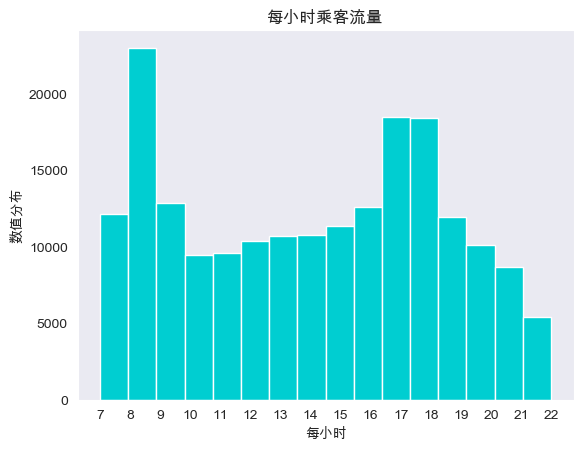

In [39]:
# 绘制直方图
fig = plt.figure()
ax = fig.add_subplot(111)
plt.grid()  # 设置网格模式
ax.hist(df['hours'], bins=16, color='#00CED1', edgecolor='white')
plt.title('每小时乘客流量')
plt.xlabel('每小时')
plt.ylabel('数值分布')
# 设置坐标轴刻度
x_list = [x for x in range(7, 23)]
plt.xticks(x_list)
plt.show()

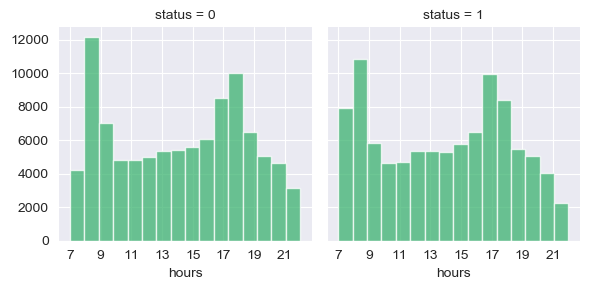

In [40]:
# 根据进出站状态对直方图进行调整
g = sns.FacetGrid(df, col='status')
g.map(plt.hist, 'hours', color='#3CB371', edgecolor='white', alpha=.75, bins=16)
x_list = [x for x in range(7, 23, 2)]
plt.xticks(x_list)
plt.show()

<font size=5>  **小结** </font>

- 约有2000条用户ID重复，可能与payTpye = 3有关；
- 根据上述分析可得，早上 `[8:00-9:00]` 以及 晚上 `[17:00-18:00]` 地铁站客流量最大。

### 4、 从时间角度进行分析

- 按天分析，分别对节假日情况、周内情况、周末情况进行分析；
- 按时间段分析，分析各个时段的进出站情况；
- 按早晚高峰分析，假设早高峰是 `7:00-9:00`，晚高峰是 `17:00 - 20:00`。


#### 4.1 线路A各个地铁站点压力情况

In [41]:
df2 = df[(df['lineID'] == 'A')]
df2.head()

,time,lineID,stationID,deviceID,status,userID,payType,date1,date2,hours
11,2022-01-01 15:24:45,A,75,3407,0,B18afab4740da695f296e1c9cd509e0ea,1,2022-01-01,15:24:45,15
13,2022-01-01 21:53:26,A,67,3134,0,Bb06e2f019f1ceb6f5417bd0180c6f1f5,1,2022-01-01,21:53:26,21
31,2022-01-01 13:23:24,A,67,3129,1,C00c73dda8ab928d4d3ad05043acdbc10,2,2022-01-01,13:23:24,13
32,2022-01-01 13:13:13,A,74,3381,0,C223eff6d5caac0dd0f41ec9e8b1f8be4,2,2022-01-01,13:13:13,13
39,2022-01-01 12:34:53,A,71,3274,1,Bac588d271ececc273a789e83cf5254af,1,2022-01-01,12:34:53,12


In [42]:
# 对 stationID 进行升序排列
df2 = df2.sort_values(by='stationID', ascending=True)
df2.head(10)

,time,lineID,stationID,deviceID,status,userID,payType,date1,date2,hours
139556,2022-01-14 17:39:07,A,67,3134,0,B07a07235fc42e0ef06f71a934789f5fa,1,2022-01-14,17:39:07,17
192207,2022-01-20 19:23:16,A,67,3124,0,D77d12562e0a0fc94ff1a416286c1a2ff,3,2022-01-20,19:23:16,19
106515,2022-01-11 11:46:36,A,67,3126,1,B803c89c9efaf607f3bdce860f3ee1af8,1,2022-01-11,11:46:36,11
9523,2022-01-01 18:00:15,A,67,3126,1,Cad5b7f0be9c8c2f39460133061f372ba,2,2022-01-01,18:00:15,18
23081,2022-01-03 11:26:59,A,67,3134,0,Cb1b86ee716bec8e6d8fecec074b6e01e,2,2022-01-03,11:26:59,11
185712,2022-01-19 17:06:51,A,67,3135,0,Bf196c23a5116c4491069c6ac4c5c14a8,1,2022-01-19,17:06:51,17
89452,2022-01-09 20:30:58,A,67,3136,0,C01ed707cc88386562c95730893a054d3,2,2022-01-09,20:30:58,20
167921,2022-01-17 08:37:33,A,67,3125,1,D074d90661efb73a482344d7df0b8ea13,3,2022-01-17,08:37:33,8
61699,2022-01-07 18:44:56,A,67,3123,0,B88849553bdf18e069c7da8c36f3188df,1,2022-01-07,18:44:56,18
9452,2022-01-01 22:21:03,A,67,3136,0,B6102272a00963316434e905521b92e8d,1,2022-01-01,22:21:03,22


In [44]:
# 查看 stationID 中的站点刷卡情况
arr = df2['stationID'].value_counts().sort_index()
print(arr)

stationID
67    1070
68    1038
69    1683
70    1606
71    1108
72     643
73    1734
74     523
75    2079
76    2611
77    2337
78    2914
79    1009
80     784
Name: count, dtype: int64


In [45]:
# 根据 arr.index 得出 stationID 中的站点情况，进行数值统计并可视化分析

def num_station_id(num):
    return df2[df2['stationID'] == num]


# 调用函数求值
x_67 = num_station_id(67.0)
x_68 = num_station_id(68.0)
x_69 = num_station_id(69.0)
x_70 = num_station_id(70.0)
x_71 = num_station_id(71.0)
x_72 = num_station_id(72.0)
x_73 = num_station_id(73.0)
x_74 = num_station_id(74.0)
x_75 = num_station_id(75.0)
x_76 = num_station_id(76.0)
x_77 = num_station_id(77.0)
x_78 = num_station_id(78.0)
x_79 = num_station_id(79.0)
x_80 = num_station_id(80.0)

# 将 每个站点的数值情况填入数组 arr2
arr2 = [x_67.shape[0], x_68.shape[0], x_69.shape[0], x_70.shape[0],
        x_71.shape[0], x_72.shape[0], x_73.shape[0], x_74.shape[0],
        x_75.shape[0], x_76.shape[0], x_77.shape[0], x_78.shape[0],
        x_79.shape[0], x_80.shape[0]]
arr2

[1070,
 1038,
 1683,
 1606,
 1108,
 643,
 1734,
 523,
 2079,
 2611,
 2337,
 2914,
 1009,
 784]

#### 对A线路各站点人流量（刷卡记录）进行分析，并绘制饼图

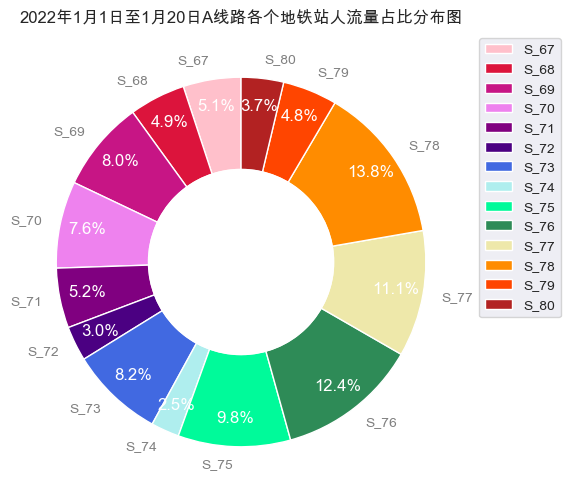

In [47]:
# 根据 arr2中的数值，画出 2022年1月1日至1月20日A线路各个地铁站人流量占比分布图
import matplotlib.pyplot as plt

# 定义数据
labels = ['S_67', 'S_68', 'S_69', 'S_70', 'S_71', 'S_72', 'S_73',
          'S_74', 'S_75', 'S_76', 'S_77', 'S_78', 'S_79', 'S_80']
sizes = arr2
colors = ['#FFC0CB', '#DC143C', '#C71585', '#EE82EE', '#800080', '#4B0082', '#4169E1',
          '#AFEEEE', '#00FA9A', '#2E8B57', '#EEE8AA', '#FF8C00', '#FF4500', '#B22222']

inner_radius = 0.5

fig, ax = plt.subplots(figsize=(6, 6))
ax.set_title('2022年1月1日至1月20日A线路各个地铁站人流量占比分布图')

# 绘制饼图
wedges, texts, autotexts = ax.pie(sizes, 
                                  labels=labels,
                                  colors=colors, 
                                  autopct='%1.1f%%', 
                                  startangle=90,
                                  pctdistance=0.85, 
                                  wedgeprops=dict(width=0.5, edgecolor='w'))
ax.legend(wedges, labels, loc='best', bbox_to_anchor=(1, 1))
for text, autotext in zip(texts, autotexts):
    text.set_color('grey')
    autotext.set_color('white')
    autotext.set_fontsize(12)

# 设置内圆半径
centre_circle = plt.Circle((0, 0), inner_radius, color='white', fc='white', linewidth=1.25)
fig.gca().add_artist(centre_circle)

# 显示图形
plt.show()

### 4.2 元旦期间乘客流量情况分析

<font size=3> **分析前提：假设节假日会比平时人流量大。**</font>
- 将`1月1日` 与 `1月2日` 两天的数据进行组合，建立新表；
- 分析各个线路、地铁站、之间的情况；
- 分别与周内、周末进行对比。

#### 根据 `date1列` 筛选出 `2022-01-01` 和 `2022-01-02`两天的数据，给到表`df3`

In [48]:
# 使用逻辑运算进行数据筛选
df3 = df[(df['date1'] == '2022-01-01') | (df['date1'] == '2022-01-02')]
print(df3.shape)
df3.head()

(19549, 10)


,time,lineID,stationID,deviceID,status,userID,payType,date1,date2,hours
0,2022-01-01 14:34:23,B,19,1006,1,Cff263245447d6ad1fbc2c6166582234e,2,2022-01-01,14:34:23,14
1,2022-01-01 18:35:52,C,47,2271,1,A27aff32d8340333a616d62e12434ccbe,0,2022-01-01,18:35:52,18
2,2022-01-01 19:35:45,B,17,952,1,Bedb7c79d26ae95c2a9f14b51b3797ed8,1,2022-01-01,19:35:45,19
3,2022-01-01 21:00:03,B,27,1351,1,Cb32ccd5e11669b4c7c5e59fc3ffe7dba,2,2022-01-01,21:00:03,21
4,2022-01-01 15:47:29,B,0,0,0,D964f8837a1a6326d0fe6bb36457874de,3,2022-01-01,15:47:29,15


#### 为了定量分析，对`表df3`按行随机抽取`19512条数据`，重新赋值给表df3

In [50]:
# 对表df3按行随机抽取19512条数据（行数据），重新赋值给表df3
# DataFrame.sample(n=None, frac=None, replace=False, weights=None, random_state=None, axis=None)[source]
df3 = df3.sample(n=19512, axis=0)
df3.head()

,time,lineID,stationID,deviceID,status,userID,payType,date1,date2,hours
13969,2022-01-02 22:12:23,C,62,2909,0,B2d6fb1049032cd1b3a2c318c4e2d1ffc,1,2022-01-02,22:12:23,22
3875,2022-01-01 10:37:42,C,38,1789,0,B2e1173159cd13ee428beb6f7ed4ff1f0,1,2022-01-01,10:37:42,10
19255,2022-01-02 13:34:20,B,5,235,0,B8ad7e20563487803c9dda9d050de7903,1,2022-01-02,13:34:20,13
15162,2022-01-02 18:12:33,C,44,2038,0,B3c29a08569bcce96cfcc6fac028fc521,1,2022-01-02,18:12:33,18
7964,2022-01-01 18:55:29,B,18,984,0,Bdde39510b017ac83aa4098ec0aa2ba02,1,2022-01-01,18:55:29,18


In [51]:
# 计算三条线路的进出站情况

# 线路A
df3_A_0 = df3[(df3['lineID'] == 'A') & (df3['status'] == 0)]
df3_A_1 = df3[(df3['lineID'] == 'A') & (df3['status'] == 1)]

# 线路B
df3_B_0 = df3[(df3['lineID'] == 'B') & (df3['status'] == 0)]
df3_B_1 = df3[(df3['lineID'] == 'B') & (df3['status'] == 1)]

# 线路C
df3_C_0 = df3[(df3['lineID'] == 'C') & (df3['status'] == 0)]
df3_C_1 = df3[(df3['lineID'] == 'C') & (df3['status'] == 1)]

# 数值打印检测
# print(df3_A_1.shape[0], df3_A_0.shape[0])
# print(df3_B_1.shape[0], df3_B_0.shape[0])
# print(df3_C_1.shape[0], df3_C_0.shape[0])

<font size=4 color=#0000dd>绘制饼图+圆环的组合图，要求饼图1半径为1.2，饼图2半径为1</font>


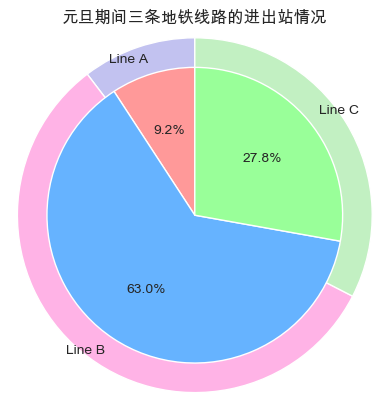

In [52]:
# 绘制元旦期间三条地铁线路的进出站百分比图

# 数据
labels = ['Line A', 'Line B', 'Line C']
sizes1 = [df3_A_0.shape[0], df3_B_0.shape[0], df3_C_0.shape[0]]
sizes2 = [df3_A_1.shape[0], df3_B_1.shape[0], df3_C_1.shape[0]]

# 绘制饼图1
plt.pie(sizes1, radius=1.2, colors=['#c2c2f0', '#ffb3e6', '#c2f0c2'], startangle=90)

# 绘制饼图2
plt.pie(sizes2, labels=labels, autopct='%1.1f%%', startangle=90, radius=1, colors=['#ff9999', '#66b3ff', '#99ff99'])

# 添加标题
plt.title('元旦期间三条地铁线路的进出站情况')

# 显示图形
plt.show()


In [53]:
# 选取周内两天作为对比：这里以 1月3日(周一) 和 1月5日（周三）为例，对三条线路情况进行分析

df4 = df[(df['date1'] == '2022-01-03') | (df['date1'] == '2022-01-05')]
df4 = df4.sample(n=19512, axis=0)
df4.shape

(19512, 10)

In [54]:
df4.sample(n=10).head()

,time,lineID,stationID,deviceID,status,userID,payType,date1,date2,hours
29770,2022-01-03 10:15:35,B,15,804,1,B70456b25cbab1b80e3920543ad1ccc33,1,2022-01-03,10:15:35,10
20371,2022-01-03 07:46:18,B,10,542,0,A66418697fe600c5e608a4f114c39641a,0,2022-01-03,07:46:18,7
22729,2022-01-03 07:34:53,B,26,1320,1,B71f177de72bf12132465074303a5c220,1,2022-01-03,07:34:53,7
22895,2022-01-03 19:06:56,C,43,1987,0,A31372c24f04b0488e2c1f2ef96582af5,0,2022-01-03,19:06:56,19
41044,2022-01-05 19:49:00,C,49,2359,1,B5cf3185a5ee9b35d1932536f7ca9956a,1,2022-01-05,19:49:00,19


In [55]:
# 计算三条线路的进出站情况

# 线路A
df4_A_0 = df4[(df4['lineID'] == 'A') & (df4['status'] == 0)]
df4_A_1 = df4[(df4['lineID'] == 'A') & (df4['status'] == 1)]

# 线路B
df4_B_0 = df4[(df4['lineID'] == 'B') & (df4['status'] == 0)]
df4_B_1 = df4[(df4['lineID'] == 'B') & (df4['status'] == 1)]

# 线路C
df4_C_0 = df4[(df4['lineID'] == 'C') & (df4['status'] == 0)]
df4_C_1 = df4[(df4['lineID'] == 'C') & (df4['status'] == 1)]

# 数值打印检测
# print(df4_A_1.shape[0], df4_A_0.shape[0])
# print(df4_B_1.shape[0], df4_B_0.shape[0])
# print(df4_C_1.shape[0], df4_C_0.shape[0])

In [56]:
# 选取周末两天作为对比：这里选择 1月7日(周六) 和 1月8日（周日）为例，对三条线路情况进行分析

df5 = df[(df['date1'] == '2022-01-07') | (df['date1'] == '2022-01-08')]
df5.shape

(19512, 10)

In [57]:
# 计算三条线路的进出站情况

# 线路A
df5_A_0 = df5[(df5['lineID'] == 'A') & (df5['status'] == 0)]
df5_A_1 = df5[(df5['lineID'] == 'A') & (df5['status'] == 1)]

# 线路B
df5_B_0 = df5[(df5['lineID'] == 'B') & (df5['status'] == 0)]
df5_B_1 = df5[(df5['lineID'] == 'B') & (df5['status'] == 1)]

# 线路C
df5_C_0 = df5[(df5['lineID'] == 'C') & (df5['status'] == 0)]
df5_C_1 = df5[(df5['lineID'] == 'C') & (df5['status'] == 1)]

# 数值打印检测
# print(df5_A_1.shape[0], df5_A_0.shape[0])
# print(df5_B_1.shape[0], df5_B_0.shape[0])
# print(df5_C_1.shape[0], df5_C_0.shape[0])

<font size=4 color=#0000dd>绘制横向柱状图</font>

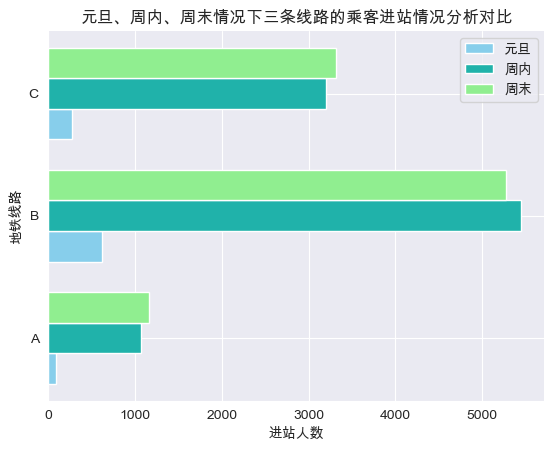

In [58]:
# 元旦(df3)、周内(df4)、周末(df5)情况下三条线路的乘客进站情况分析对比

import matplotlib.pyplot as plt
import numpy as np

# 数据
data = np.array([[df3_A_1.shape[0], df3_B_1.shape[0], df3_C_1.shape[0]],
                 [df4_A_1.shape[0], df4_B_1.shape[0], df4_C_1.shape[0]],
                 [df5_A_1.shape[0], df5_B_1.shape[0], df5_C_1.shape[0]]]
                )

name = ["元旦", "周内", "周末"]

# 颜色
colors = ['#87CEEB', '#20B2AA', '#90EE90']

# 宽度
width = 0.25

# 绘图
fig, ax = plt.subplots()
for i in range(data.shape[0]):
    ax.barh(np.arange(data.shape[1]) + i * width, data[i], width, color=colors[i], label=name[i])

plt.title('元旦、周内、周末情况下三条线路的乘客进站情况分析对比')

# 坐标轴标签
ax.set_xlabel('进站人数')
ax.set_ylabel('地铁线路')
# 设置刻度
ax.set_yticks([0.25, 1.25, 2.25])
# 设置刻度标签
ax.set_yticklabels(['A', 'B', 'C'])
# 图例
ax.legend()

# 美化
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.show()

<font size=5> **小结** </font>

- 根据饼图结果可得，元旦期间，`地铁线路B` 的客流量占总体的 `60%` 左右；
- 根据条形图结果可得，可知周内期间 `地铁线路B` 高出节假日和周末大概`2000人` 左右
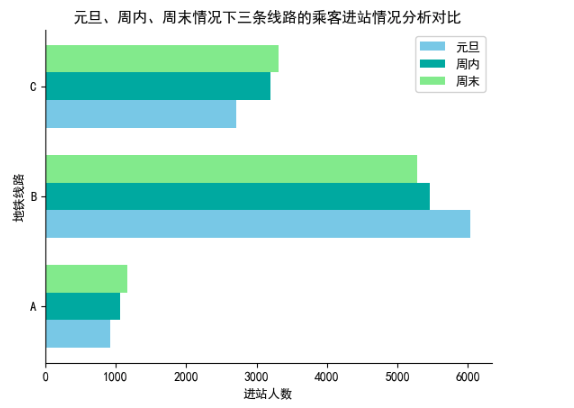

## 4.3 分析某一天的客流量情况

- 以 `2022-01-16` 当天的数据为例，分析各个时间段的进出站情况
- 假设早高峰是 `7:00-9:00`，晚高峰是 `17:00 - 20:00`，分析 `2022-01-16` 当天的早晚高峰情况。

<font size=4 color=#0000dd>将 data表中 `date1列`中所有`2022-01-16`这一天的数据提取出来，赋值给`表df6`</font>

In [ ]:
df6 = df[(df['date1'] == '2022-01-16')]
print(df6.shape)
df6.head()

In [ ]:
# 对 df6 按 hours 这一列 升序排列

df6 = df6.sort_values(by='hours', ascending=True)
df6.head(10)

In [ ]:
# 线路 A 每小时乘客记录统计
df6_A = df6[df6['lineID'] == 'A']
df6_A['hours'].value_counts()

<font size=4 color=#0000dd>按照`df6_A`的方法，筛选出线路B和线路C</font>

In [ ]:
# 线路 B 每小时乘客记录统计
df6_B = df6[df6['lineID'] == 'B']
df6_B['hours'].value_counts()

In [ ]:
# 线路 C 每小时乘客记录统计
df6_C = df6[df6['lineID'] == 'C']
df6_C['hours'].value_counts()

In [ ]:
# 对线路A、B、C每个时间段进出站人数情况的可视化分析

# 数据
category_names = ['LineA', 'LineB', 'LineC']
results = {
    '7点-9点': [326, 1527, 992],
    '10点-12点': [114, 801, 396],
    '13点-15点': [161, 891, 379],
    '16点-18点': [311, 1327, 827],
    '19点-21点': [171, 817, 491],
    '22点-24点': [23, 136, 92]
}


# 绘图
def survey(results, category_names):
    labels = list(results.keys())
    data = np.array(list(results.values()))
    data_cum = data.cumsum(axis=1)
    category_colors = plt.get_cmap('RdYlGn')(np.linspace(0.15, 0.85, data.shape[1]))

    fig, ax = plt.subplots(figsize=(9.2, 5))
    ax.invert_yaxis()
    ax.xaxis.set_visible(False)
    ax.set_xlim(0, np.sum(data, axis=1).max())

    for i, (colname, color) in enumerate(zip(category_names, category_colors)):
        widths = data[:, i]
        starts = data_cum[:, i] - widths
        rects = ax.barh(labels, widths, left=starts, height=0.5,
                        label=colname, color=color)
    #        ax.text(color, colname, labels[i], ha='center')
    #
    #        r, g, b, _ = color
    #        text_color = 'white' if r * g * b < 0.5 else 'darkgrey'
    #        ax.bar_label(rects, label_type='center', color=text_color)
    #    ax.legend(ncols=len(category_names), bbox_to_anchor=(0, 1),
    #                loc='lower left', fontsize='small')

    return fig, ax


survey(results, category_names)
plt.legend()
plt.show()

<font size=5> **小结** </font>

- 根据上述图示结果可得，`2022-01-16` 这一天中，7点到9点以及16点到18点，各个线路的乘客流量都比较大，值得注意的是压力最大的线路仍然是线路B。

## 4.4  早晚高峰情况分析



<font size=4 color=#0000dd>根据`表df6`中的`hours列`筛选出`7点至9点`的所有数据</font>

In [ ]:
# 早高峰

MornPeak = df6[(df6['hours'] >= 7) & (df6['hours'] <= 9)]
MornPeak.shape

In [ ]:
MornPeak.sample(n=10)

In [ ]:
# 提取早高峰线路A、B、C进出站数据
def MornExtract(name):
    a_1 = MornPeak[(MornPeak['lineID'] == name) & (MornPeak['status'] == 1.0)]
    a_0 = MornPeak[(MornPeak['lineID'] == name) & (MornPeak['status'] == 0.0)]

    return a_1, a_0


lineA_1, lineA_0 = MornExtract('A')
lineB_1, lineB_0 = MornExtract('B')
lineC_1, lineC_0 = MornExtract('C')

# print(lineA_1.shape[0], lineA_0.shape[0])
# print(lineB_1.shape[0], lineB_0.shape[0])
# print(lineC_1.shape[0], lineC_0.shape[0])

In [ ]:
# 创建新表
columns = ['lineID', 'status_1', 'status_0']
values = [['A', lineA_1.shape[0], lineA_0.shape[0]], ['B', lineB_1.shape[0], lineB_0.shape[0]],
          ['C', lineC_1.shape[0], lineC_0.shape[0]]]
NMPeak = pd.DataFrame(data=values, index=None, columns=columns)
NMPeak.head()

In [ ]:
# 晚高峰
EvenPeak = df6[(df6['hours'] >= 17) & (df6['hours'] <= 20)]
EvenPeak.shape

In [ ]:
EvenPeak.sample(n=10)

<font size=4 color=#0000dd>根据早高峰提取函数`def MornExtract(name):` 完善晚高峰提取函数</font>

In [ ]:
# 提取晚高峰线路A、B、C进出站数据

def even_extract(name):
    a_1 = EvenPeak[(EvenPeak['lineID'] == name) & (EvenPeak['status'] == 1.0)]
    a_0 = EvenPeak[(EvenPeak['lineID'] == name) & (EvenPeak['status'] == 0.0)]

    return a_1, a_0


E_lineA_1, E_lineA_0 = even_extract('A')
E_lineB_1, E_lineB_0 = even_extract('B')
E_lineC_1, E_lineC_0 = even_extract('C')

# print(E_lineA_1.shape[0], E_lineA_0.shape[0])
# print(E_lineB_1.shape[0], E_lineB_0.shape[0])
# print(E_lineC_1.shape[0], E_lineC_0.shape[0])

In [ ]:
# 创建新表
columns = ['lineID', 'status_1', 'status_0']
values = [['A', E_lineA_1.shape[0], E_lineA_0.shape[0]], ['B', E_lineB_1.shape[0], E_lineB_0.shape[0]],
          ['C', E_lineC_1.shape[0], E_lineC_0.shape[0]]]
NEPeak = pd.DataFrame(data=values, index=None, columns=columns)
NEPeak.head()

<font size=4 color=#0000dd>绘制堆叠柱状图，绘制子图</font>

In [ ]:
# 设置图像大小为（10,10）
fig = plt.figure(figsize=(10, 8), dpi=80)

## 早高峰图
plt.subplot(1, 2, 1)
plt.bar(NMPeak['lineID'], NMPeak['status_1'], align='center', width=0.4, color='#66c2a5',
        tick_label='Line' + NMPeak['lineID'], label='进站')
plt.bar(NMPeak['lineID'], NMPeak['status_0'], width=0.4, bottom=NMPeak['status_1'], color='#8da0cb', label='出站')

plt.title("2022年1月1日至1月20日A、B、C三条地铁线的早高峰情况")
# 设置x轴标签
plt.xlabel('地铁线路')
# 设置y轴标签
plt.ylabel('进出站情况')
# 刻度标签倾斜60度
plt.xticks(rotation=60)
# 显示图例
plt.legend()

## 晚高峰图
plt.subplot(1, 2, 2)

# 颜色
colors = ['#FF7F50', '#0000FF']

# 绘图
plt.bar(NEPeak['lineID'], NEPeak['status_1'], align='center', width=0.4, color='#66c2a5',
        tick_label='Line' + NEPeak['lineID'], label='进站')
plt.bar(NEPeak['lineID'], NEPeak['status_0'], width=0.4, bottom=NEPeak['status_1'], color='#8da0cb', label='出站')

plt.title("2022年1月1日至1月20日A、B、C三条地铁线的晚高峰情况")

# 设置x轴标签
plt.xlabel('地铁线路')
# 设置y轴标签
plt.ylabel('进出站情况')
# 刻度标签倾斜60度
plt.xticks(rotation=60)
# 显示图例
plt.legend()
plt.show()


<font size=5> **小结** </font>

- 根据上述图示结果可以清晰的看到 `2022-01-16` 这一天早晚高峰各条线路的进出站情况，压力最大的线路是`B`，其次是线路 `C`, 压力最小的线路是 `A`